# How to handle errors during optimization

## Try to avoid errors

Often, optimizers try quite extreme parameter vectors, which then can raise errors in your criterion function or derivative. Often, there are simple tricks to make your code more robust. Avoiding errors is always better than dealing with errors after they occur.  

- Avoid to take ``np.exp`` without further safeguards. With 64 bit floating point numbers, the exponential function is only well defined roughly between -700 and 700. Below it is 0, above it is inf. Sometimes you can use ``scipy.special.logsumexp`` to avoid unsafe evaluations of the exponential. Read [this](https://en.wikipedia.org/wiki/LogSumExp) for background information on the logsumexp trick.
- Set bounds for your parameters that prevent extreme parameter constellations.
- Use the ``bounds_distance`` option with a not too small value for ``covariance`` and ``sdcorr`` constraints.
- Use `estimagic.utilities.robust_cholesky` instead of normal
  cholesky decompositions or try to avoid cholesky decompositions.
- Use a less aggressive optimizer. Trust region optimizers like `fides` usually choose less extreme steps in the beginnig than line search optimizers like `scipy_bfgs` and `scip_lbfgsb`. 

## Do not use clipping

A commonly chosen solution to numerical problems is clipping of extreme values. Naive clipping leads to flat areas in your criterion function and can cause spurious convergence. Only use clipping if you know that your optimizer can deal with flat parts. 

## Let estimagic do its magic

Instead of avoiding errors in your criterion function, you can raise them and let estimagic deal with them. If you are using numerical derivatives, errors will automatically be raised if any entry in the derivative is not finite. 

### An example

Let's look at a simple example from the Moré-Wild benchmark set that has a numerical instability. 

In [1]:
import warnings

import numpy as np
import pandas as pd
from scipy.optimize import minimize as scipy_minimize

import estimagic as em

warnings.simplefilter("ignore")

In [2]:
def jennrich_sampson(x):
    dim_out = 10
    fvec = (
        2 * (1.0 + np.arange(1, dim_out + 1))
        - np.exp(np.arange(1, dim_out + 1) * x[0])
        - np.exp(np.arange(1, dim_out + 1) * x[1])
    )
    return fvec @ fvec


correct_params = np.array([0.2578252135686162, 0.2578252135686162])
correct_criterion = 124.3621823556148

start_x = np.array([0.3, 0.4])

### What would scipy do?

In [3]:
scipy_res = scipy_minimize(jennrich_sampson, x0=start_x, method="L-BFGS-B")

In [4]:
scipy_res.success

True

In [5]:
correct_params.round(4), scipy_res.x.round(4)

(array([0.2578, 0.2578]), array([0.3384, 0.008 ]))

So, scipy thinks it solved the problem successfully but the result is far off. (Note that scipy would have given us a warning, but we disabled warnings in order to not clutter the output).

### Estimagic's error handling magic

In [6]:
res = em.minimize(
    criterion=jennrich_sampson,
    params=start_x,
    algorithm="scipy_lbfgsb",
    error_handling="continue",
)

correct_params, res.params

(array([0.25782521, 0.25782521]), array([0.25782521, 0.25782522]))

### How does the magic work

When an error occurs and `error_handling` is set to `"continue"`, estimagic replaces your criterion with a dummy function (and adjusts the derivative accordingly). 

The dummy function has two important properties:

1. Its value is always higher than criterion at start params. 
2. Its slope guides the optimizer back towards the start parameters. I.e., if you are minimizing, the direction of strongest decrease is towards the start parameters; if you are maximizing, the direction of strongest increase is towards the start parameters. 

Therefore, when hitting an undefined area, an optimizer can take a few steps back until it is in better territory and then continue its work. 

Importantly, the optimizer will not simply go back to a previously evaluated point (which would just lead to cyclical behavior). It will just go back in the direction it originally came from.

In the concrete example, the dummy function would look similar to the following:

In [7]:
def dummy(params):
    start_params = np.array([0.3, 0.4])
    # this is close to the actual value used by estimagic
    constant = 8000
    # the actual slope used by estimagic would be even smaller
    slope = 10_000
    diff = params - start_params
    return constant + slope * np.linalg.norm(diff)

Now, let's plot the two functions. For better illustration, we assume that the jennrich_sampson function is only defined until it reaches a value of 100_000 and the dummy function takes over from there.  

In [8]:
from plotly import graph_objects as go

grid = np.linspace(0, 1)
params = [np.full(2, val) for val in grid]
values = np.array([jennrich_sampson(p) for p in params])
values = np.where(values <= 1e5, values, np.nan)
dummy_values = np.array([dummy(p) for p in params])
dummy_values = np.where(np.isfinite(values), np.nan, dummy_values)

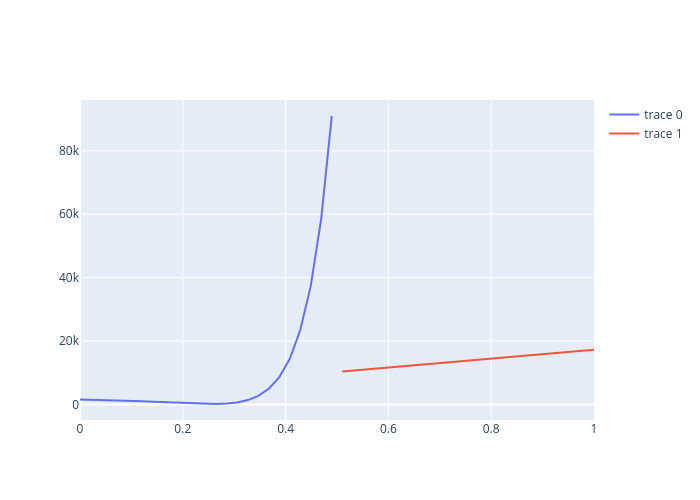

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=grid, y=values))
fig.add_trace(go.Scatter(x=grid, y=dummy_values))
fig.show(renderer="png")

We can see that the dummy function is lower than the highest achieved value of `jennrich_sampson` but higher than the start values. It is also rather flat. Fortunately, that is all we need. 